In [1]:
try:
    # Import necessary libraries
    import os
    import requests
    import logging
    from typing import Dict, List, Optional, Set, Tuple
    from collections import defaultdict
    from IPython.display import display
    import requests
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import folium
    from geopy.distance import geodesic
    from dotenv import load_dotenv

    # Configure logging
    logging.basicConfig(level=logging.INFO, format='%(message)s')
    logger = logging.getLogger(__name__)

    load_dotenv('../Docs/.env')
    app_key = os.getenv('app_key')

    if not app_key:
        logger.error("No TfL API key found")

except Exception as e:
    print(f"Error : {e}")

In [2]:
base_url = 'https://api.tfl.gov.uk'

# Get all stations and their information
# Official TfL line colors
line_colors = {
    'bakerloo': '#B36305',
    'central': '#DC241F',
    'circle': '#FFD300',
    'district': '#00782A',
    'hammersmith-city': '#F3A9BB',
    'jubilee': '#A0A5A9',
    'metropolitan': '#9B0056',
    'northern': '#000000',
    'piccadilly': '#003688',
    'victoria': '#0098D4',
    'waterloo-city': '#95CDBA'
}

# Station colors
station_colors = {
    'regular': 'white',
    'interchange': 'grey',
    'edge': 'black'
}

In [3]:
# Fetch stations
try:
    response = requests.get(
        'https://api.tfl.gov.uk/StopPoint/Mode/tube',
        params={'app_key': app_key}
    )
    response.raise_for_status()
    stations = response.json()
except requests.RequestException as e:
    logger.error(f"Error fetching station data: {e}")
    stations = None

# Fetch lines
try:
    response = requests.get(
        'https://api.tfl.gov.uk/Line/Mode/tube',
        params={'app_key': app_key}
    )
    response.raise_for_status()
    lines = response.json()
except requests.RequestException as e:
    logger.error(f"Error fetching line data: {e}")
    lines = None

In [4]:
# Initialize data structures
station_lines = defaultdict(set)
line_stations = defaultdict(set)

# Process stations
valid_stations = {}
for station in stations['stopPoints']:
    if station['stopType'] == 'NaptanMetroStation' and 'tube' in station['modes']:
        station_id = station['naptanId']
        valid_stations[station_id] = {
            'name': station['commonName'],
            'lat': station['lat'],
            'lon': station['lon']
        }

# Process lines and their stations
for line in lines:
    line_id = line['id']
    try:
        response = requests.get(
            f'https://api.tfl.gov.uk/Line/{line_id}/Route/Sequence/all',
            params={'app_key': app_key}
        )
        response.raise_for_status()
        line_data = response.json()

        if 'orderedLineRoutes' in line_data:
            for route in line_data['orderedLineRoutes']:
                for station_id in route['naptanIds']:
                    if station_id in valid_stations:
                        station_lines[station_id].add(line_id)
                        line_stations[line_id].add(station_id)
    except requests.RequestException as e:
        logger.warning(f"Error fetching data for line {line_id}: {e}")

# Filter lines with at least 5 stations
valid_lines = {
    line_id: stations
    for line_id, stations in line_stations.items()
    if len(stations) >= 5
}

# Select top 5 lines with most stations
if len(valid_lines) >= 5:
    selected_lines = dict(
        sorted(valid_lines.items(), key=lambda x: len(x[1]), reverse=True)[:5]
    )

    # Get stations for selected lines
    selected_stations = set()
    for stations_set in selected_lines.values():
        selected_stations.update(stations_set)

    analysis = {
        'stations': {
            station_id: {
                **valid_stations[station_id],
                'lines': station_lines[station_id]
            }
            for station_id in selected_stations
        },
        'lines': selected_lines,
        'stats': {
            'num_stations': len(selected_stations),
            'num_lines': len(selected_lines),
            'lines_info': {
                line: len(stations)
                for line, stations in selected_lines.items()
            }
        }
    }
else:
    logger.error("Insufficient data meeting requirements")
    analysis = None

In [5]:
# Initialize the graph
G = nx.Graph()

# Add stations to the graph
for station_id, station_data in analysis['stations'].items():
    station_name = station_data['name'].replace(" Underground Station", "")
    G.add_node(
        station_id,
        name=station_name,
        pos=(station_data['lon'], station_data['lat']),
        lines=station_data['lines']
    )

# Add connections between stations
for line_id in analysis['lines'].keys():
    try:
        response = requests.get(
            f'https://api.tfl.gov.uk/Line/{line_id}/Route/Sequence/all',
            params={'app_key': app_key}
        )
        response.raise_for_status()
        line_data = response.json()

        if 'orderedLineRoutes' in line_data:
            for route in line_data['orderedLineRoutes']:
                stations_list = route['naptanIds']
                for i in range(len(stations_list) - 1):
                    start_station = stations_list[i]
                    end_station = stations_list[i + 1]
                    if (G.has_node(start_station)
                        and G.has_node(end_station)
                        and not G.has_edge(start_station, end_station)):

                        # Calculate distance between stations
                        start_pos = G.nodes[start_station]['pos']
                        end_pos = G.nodes[end_station]['pos']
                        distance = geodesic(
                            (start_pos[1], start_pos[0]),
                            (end_pos[1], end_pos[0])
                        ).kilometers

                        # Add edge to the graph
                        G.add_edge(
                            start_station,
                            end_station,
                            line=line_id,
                            color=line_colors.get(line_id.lower(), '#808080'),
                            distance=round(distance, 2)
                        )
    except requests.RequestException as e:
        logger.error(f"Error fetching line data for {line_id}: {e}")

In [6]:
# Log analysis results
logger.info("Network Analysis:")
logger.info("Selected Lines:")
for line, stations in analysis['lines'].items():
    logger.info(f"- {line.title()} Line: {len(stations)} stations")
logger.info(f"Total Stations: {analysis['stats']['num_stations']}")

Network Analysis:
Selected Lines:
- District Line: 60 stations
- Piccadilly Line: 53 stations
- Northern Line: 52 stations
- Central Line: 49 stations
- Circle Line: 36 stations
Total Stations: 212


In [19]:
# Create an interactive map centered on London with a clean style and appropriate zoom level
m = folium.Map(
    location=[51.5074, -0.1278],
    zoom_start=12,
    tiles='cartodbpositron'
)

# Add lines to the map with updated styling
for (u, v, data) in G.edges(data=True):
    line_coords = [
        [G.nodes[u]['pos'][1], G.nodes[u]['pos'][0]],
        [G.nodes[v]['pos'][1], G.nodes[v]['pos'][0]]
    ]

    # Create popup content
    popup_html = f"""
        <div style="font-family: Arial, sans-serif;">
            <h4>{data['line'].title()} Line</h4>
            <p>Distance: {data['distance']:.2f} km</p>
            <p>Stations: {G.nodes[u]['name']} → {G.nodes[v]['name']}</p>
        </div>
    """

    # Add the line to the map with updated styling
    folium.PolyLine(
        line_coords,
        color=data['color'],
        weight=4,     # Thicker lines
        opacity=0.9,  # More solid lines
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# Add stations to the map with updated styling
for node, data in G.nodes(data=True):
    is_interchange = len(data['lines']) > 1

    # Create popup content
    popup_html = f"""
        <div style="font-family: Arial, sans-serif;">
            <h4>{data['name']}</h4>
            <p>Lines: {', '.join(data['lines']).title()}</p>
            <p>Type: {'Interchange' if is_interchange else 'Regular'} Station</p>
        </div>
    """

    # Add the station to the map with updated styling
    folium.CircleMarker(
        location=[data['pos'][1], data['pos'][0]],
        radius=8 if is_interchange else 5,
        color='black',
        fill=True,
        fill_color=station_colors['interchange'] if is_interchange else station_colors['regular'],
        weight=2.5 if is_interchange else 1,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# Display the map
display(m)

In [8]:
# Optionally save the map to an HTML file
m.save('TfL-Map.html')

In [9]:
# Print total number of stations and first few station names
print("Total stations:", len(G.nodes()))
print("\nFirst 5 station names:")
for station in list(G.nodes())[:5]:
    print(station)

Total stations: 212

First 5 station names:
940GZZLUBLG
940GZZLUWOP
940GZZLUBND
940GZZLUSFS
940GZZLUPKR


In [10]:
search = 'bank'

In [11]:
# Print station names and their IDs
for node, data in G.nodes(data=True):
    if 'name' in data and search in data['name'].lower():
        print(f"ID: {node}")
        print(f"Name: {data['name']}")
        print("---")

ID: 940GZZLUEMB
Name: Embankment
---
ID: 940GZZLUBNK
Name: Bank
---


In [12]:
# Use Bank station ID as center point
center_station = "940GZZLUBNK"

# Get stations within 7 stops using networkx
radius_stations = nx.single_source_shortest_path_length(G, center_station, cutoff=7)
G_subset = G.subgraph(radius_stations.keys())

# Update the plotting code to use G_subset
pos = {node: data['pos'] for node, data in G_subset.nodes(data=True)}

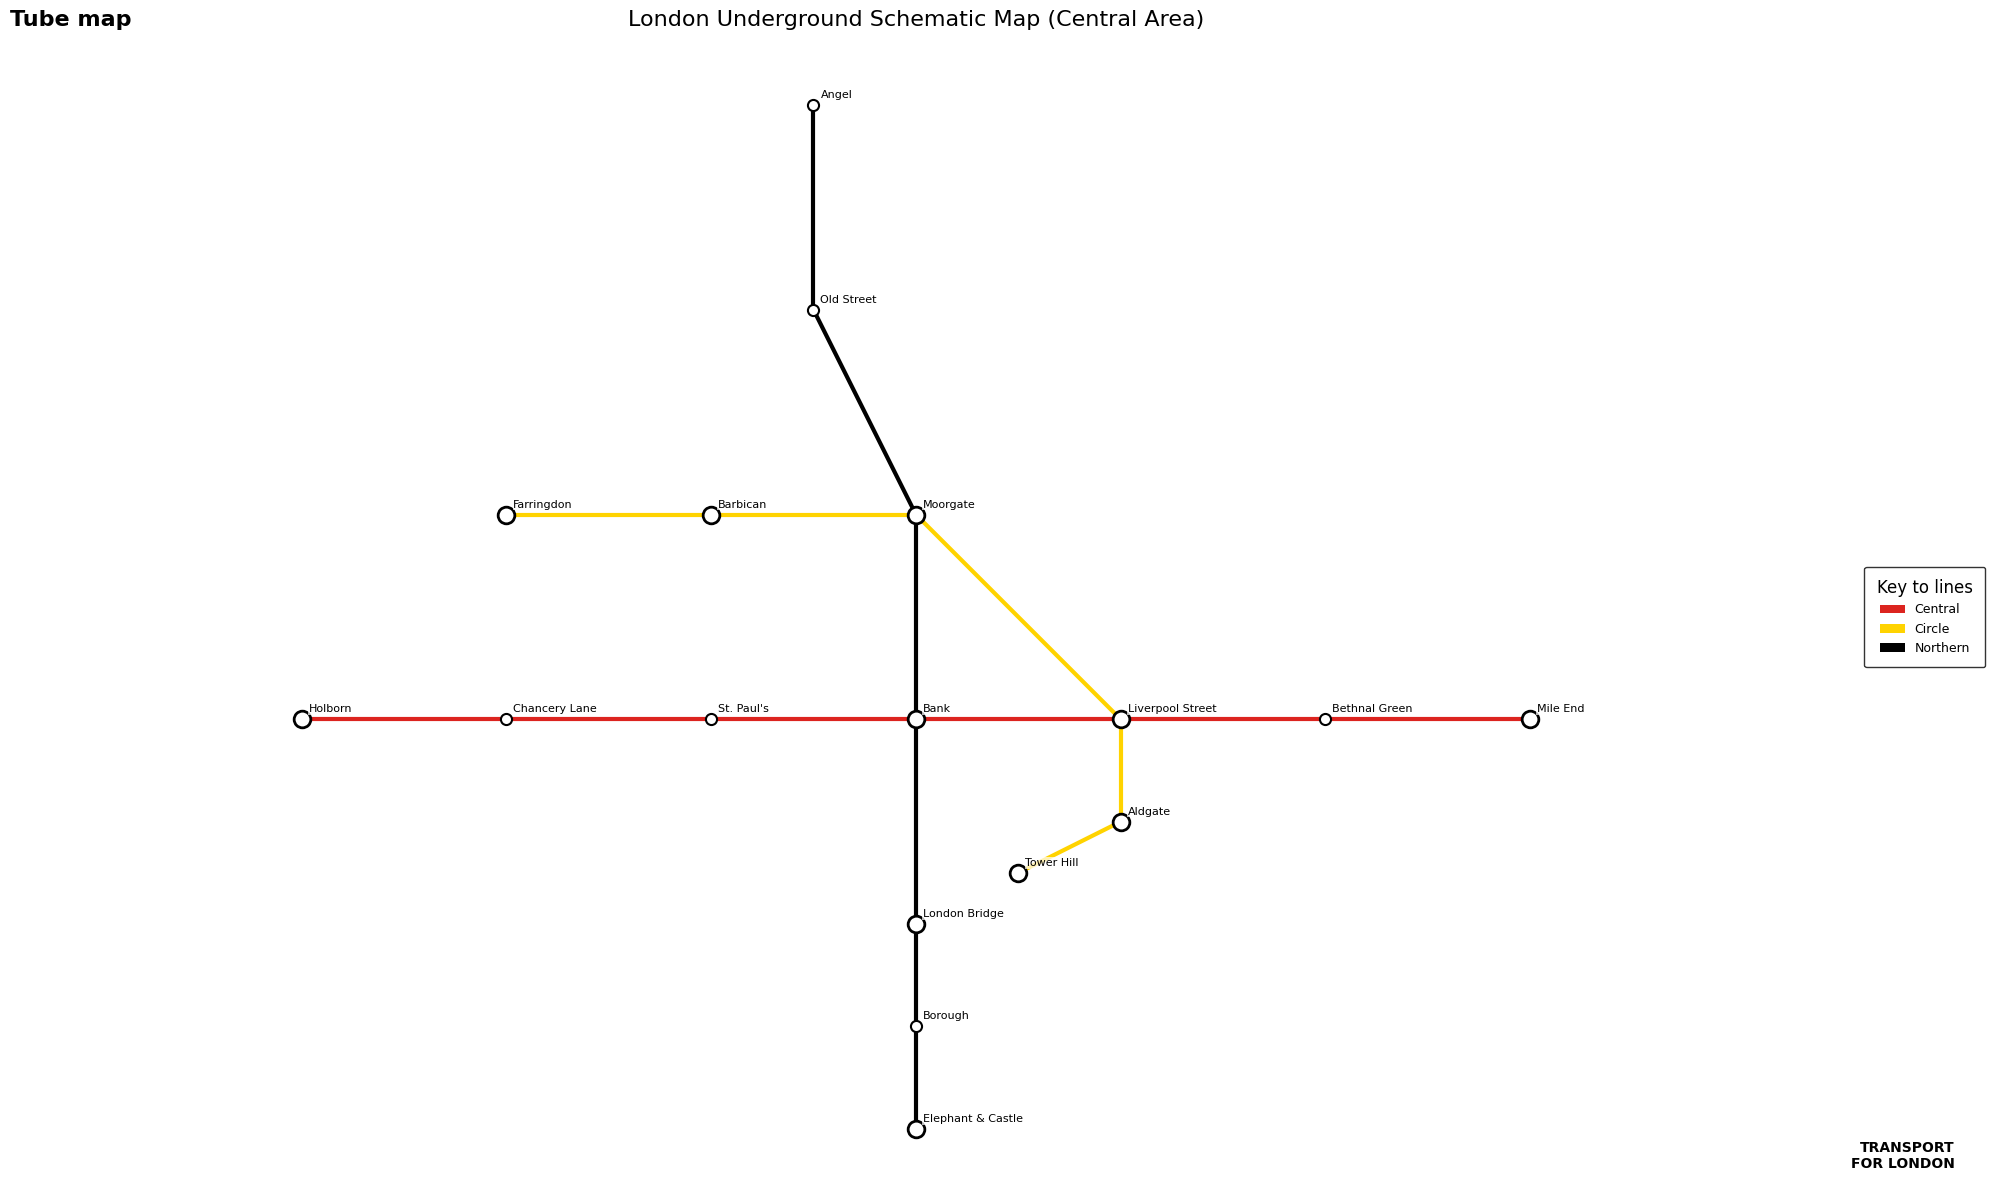

In [16]:
plt.figure(figsize=(20, 12), facecolor='white')
ax = plt.gca()
ax.set_facecolor('#F8F8F8')  # Light gray background like TfL map

# Set up grid for schematic layout
ax.grid(True, linestyle='-', alpha=0.1, zorder=0)
ax.set_axisbelow(True)

# Get stations within 7 stops using networkx
radius_stations = nx.single_source_shortest_path_length(G, center_station, cutoff=3)
G_subset = G.subgraph(radius_stations.keys())

# Then modify the plotting code to use G_subset instead of G
pos = {node: data['pos'] for node, data in G_subset.nodes(data=True)}

# Fixed coordinates for schematic layout
schematic_positions = {
    # Central Line (West to East)
    "Holborn": (-6, 0),
    "Chancery Lane": (-4, 0),
    "St. Paul's": (-2, 0),
    "Bank": (0, 0),
    "Liverpool Street": (2, 0),
    "Bethnal Green": (4, 0),
    "Mile End": (6, 0),
    
    # Circle Line (West to East)
    "Farringdon": (-4, 2),
    "Barbican": (-2, 2),
    "Moorgate": (0, 2),
    "Liverpool Street": (2, 0),  # Interchange
    "Aldgate": (2, -1),
    
    # Northern Line (North to South)
    "Angel": (-1, 6),
    "Old Street": (-1, 4),
    "Moorgate": (0, 2),          # Interchange
    "Bank": (0, 0),              # Interchange
    "London Bridge": (0, -2),
    "Borough": (0, -3),
    "Elephant & Castle": (0, -4),
    
    # Tower Hill branch
    "Tower Hill": (1, -1.5)
}

# Update positions
pos = {node: schematic_positions[data['name'].replace(' Underground Station', '')] 
       for node, data in G_subset.nodes(data=True) 
       if data['name'].replace(' Underground Station', '') in schematic_positions}

# Draw edges (lines)
drawn_lines = set()
for (u, v, data) in G_subset.edges(data=True):
    if u in pos and v in pos:  # Only draw if both stations are in our schematic
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        plt.plot(
            [x1, x2],
            [y1, y2],
            color=data['color'],
            linewidth=3,
            solid_capstyle='round',
            label=data['line'] if data['line'] not in drawn_lines else "",
            zorder=1
        )
        drawn_lines.add(data['line'])

# Draw stations
for node, data in G_subset.nodes(data=True):
    station_name = data['name'].replace(' Underground Station', '')
    if station_name in schematic_positions:
        is_interchange = len(data['lines']) > 1
        x, y = pos[node]
        
        # Draw station markers
        if is_interchange:
            # Larger white circle with black border for interchange stations
            plt.plot(x, y, 'o', color='white', markersize=12, 
                    markeredgecolor='black', markeredgewidth=2, zorder=3)
        else:
            # Regular stations
            plt.plot(x, y, 'o', color='white', markersize=8, 
                    markeredgecolor='black', markeredgewidth=1.5, zorder=2)

        # Add station labels
        plt.annotate(
            station_name,
            (x, y),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            fontweight='normal',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5),
            zorder=4
        )

# Create legend
legend_elements = []
for line_name in sorted(drawn_lines):
    line_color = next(data['color'] for _, _, data in G_subset.edges(data=True) 
                     if data['line'] == line_name)
    legend_elements.append(patches.Patch(facecolor=line_color, label=line_name.title()))

# Add legend with TfL styling
plt.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    title='Key to lines',
    title_fontsize=12,
    fontsize=9,
    frameon=True,
    edgecolor='black',
    facecolor='white',
    borderpad=1
)

# Add title and TfL branding
plt.title(
    "Tube map",
    pad=20,
    fontsize=16,
    fontweight='bold',
    fontfamily='sans-serif',
    loc='left'
)

# Add TfL logo text
plt.figtext(
    0.98, 0.02,
    'TRANSPORT\nFOR LONDON',
    fontsize=10,
    fontweight='bold',
    fontfamily='sans-serif',
    ha='right',
    va='bottom'
)

plt.title("London Underground Schematic Map (Central Area)", pad=20, fontsize=16)
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate network statistics
stats = {
    'num_stations': G.number_of_nodes(),
    'num_connections': G.number_of_edges(),
    'num_interchanges': sum(
        1 for _, data in G.nodes(data=True)
        if len(data['lines']) > 1
    ),
    'total_distance': sum(
        data['distance']
        for _, _, data in G.edges(data=True)
    ),
    'is_connected': nx.is_connected(G)
}

# Display network statistics
logger.info("Network Statistics:")
for key, value in stats.items():
    logger.info(f"{key}: {value}")

Network Statistics:
num_stations: 212
num_connections: 230
num_interchanges: 78
total_distance: 272.3200000000001
is_connected: True
